In [50]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib.colors as mcolors
import cmcrameri.cm as cmc
from tqdm import tqdm

# --- Parameters ---
num_fils = 100
num_segs = 20
num_steps = 500

# --- File Paths ---
seg_file_path = f'../data/plane_fcm_emergent_random_{num_fils}fils/20250714/ciliate_{num_fils}fil_9000blob_8.00R_0.1000torsion_0.2182tilt_0.3000f_eff_1.4960theta0_0.0000freqshift_seg_states.dat'
phase_file_path = f'../data/plane_fcm_emergent_random_{num_fils}fils/20250714/ciliate_{num_fils}fil_9000blob_8.00R_0.1000torsion_0.2182tilt_0.3000f_eff_1.4960theta0_0.0000freqshift_true_states.dat'

# --- Load Data ---
seg_data = np.loadtxt(seg_file_path)
phase_data = np.loadtxt(phase_file_path)

# --- Process Data ---
time = seg_data[:, 0] / num_steps
num_steps = len(time)

# Reshape segment data: (time, num_fils, num_segs, 3)
seg_positions = seg_data[:, 1:].reshape(num_steps, num_fils, num_segs, 3)

# Extract phases: (time, num_fils)
phases = np.mod(phase_data[:, 2:num_fils+2], 2*np.pi)


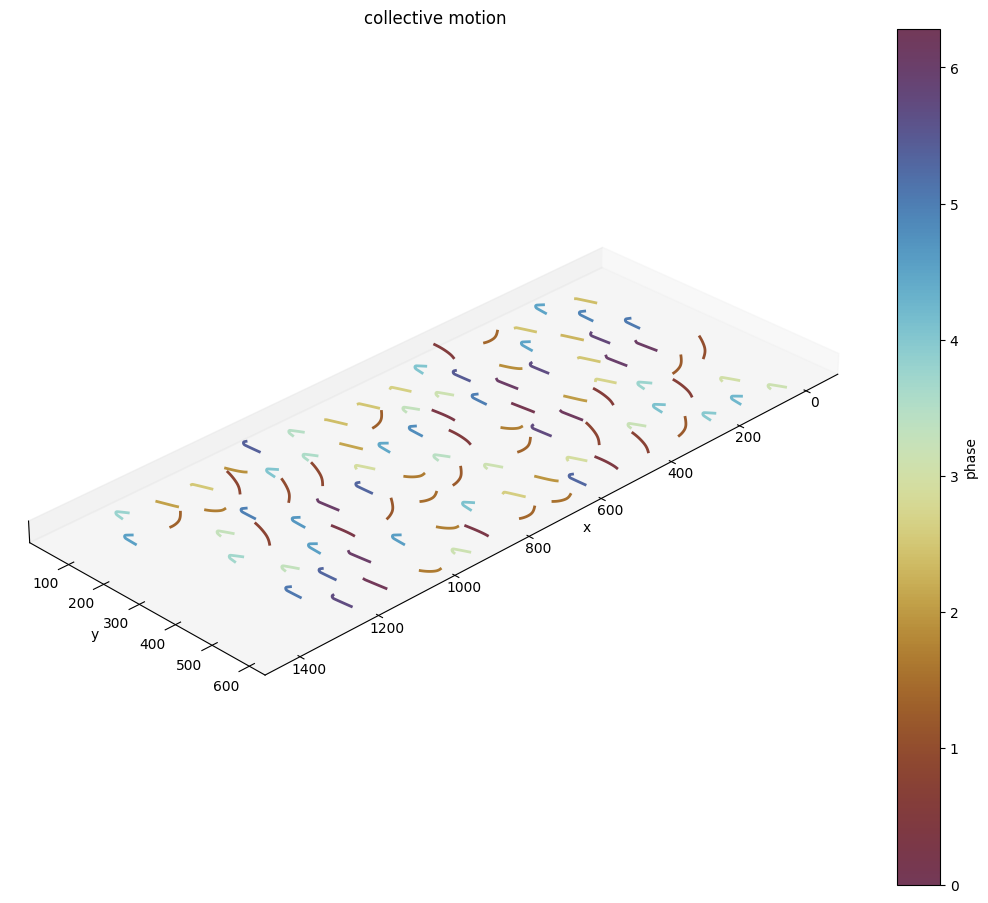

In [51]:
# --- Preview First Frame ---
fig_preview = plt.figure(figsize=(12, 12))
ax_preview = fig_preview.add_subplot(111, projection='3d')

# Setup colormap
cmap = cmc.romaO
norm = mcolors.Normalize(vmin=0, vmax=2*np.pi)

# Set axis limits based on the initial positions of the cilia
x_coords = seg_positions[0, :, :, 0]
y_coords = seg_positions[0, :, :, 1]
z_coords = seg_positions[0, :, :, 2]

margin = 100.0
ax_preview.set_xlim(np.min(x_coords) - margin, np.max(x_coords) + margin)
ax_preview.set_ylim(np.min(y_coords) , np.max(y_coords) )
ax_preview.set_zlim(np.min(z_coords) , np.max(z_coords) )

ax_preview.set_xlabel('x')
ax_preview.set_ylabel('y')
# ax_preview.set_zlabel('z')
ax_preview.set_title('collective motion')
ax_preview.set_aspect('equal')
ax_preview.grid(False)

# Hide ticks
# ax_preview.set_xticks([])
# ax_preview.set_yticks([])
ax_preview.set_zticks([])

# Set view angle
ax_preview.view_init(elev=30, azim=45)

# Plot each cilium for the first frame
for i in range(num_fils):
    cilium_positions = seg_positions[0, i, :, :]
    x_data = cilium_positions[:, 0]
    y_data = cilium_positions[:, 1]
    z_data = cilium_positions[:, 2]
    ax_preview.plot(x_data, y_data, z_data, '-', lw=2, color=cmap(norm(phases[0, i])))

# Add a colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig_preview.colorbar(sm, ax=ax_preview, orientation='vertical', fraction=0.046, pad=0.04)
cbar.set_label('phase')

plt.show()

In [52]:
# --- Animation Setup ---
fig_anim = plt.figure(figsize=(12, 12))
ax_anim = fig_anim.add_subplot(111, projection='3d')

# Create line objects for each cilium
lines = [ax_anim.plot([], [], [], '-', lw=2)[0] for _ in range(num_fils)]

# Setup colormap
cmap = cmc.romaO
norm = mcolors.Normalize(vmin=0, vmax=2*np.pi)

def init_anim():
    """Initialize the plot for animation."""
    x_coords = seg_positions[:, :, :, 0]
    y_coords = seg_positions[:, :, :, 1]
    z_coords = seg_positions[:, :, :, 2]
    
    margin = 100.0
    ax_anim.set_xlim(np.min(x_coords) - margin, np.max(x_coords) + margin)
    ax_anim.set_ylim(np.min(y_coords), np.max(y_coords))
    ax_anim.set_zlim(np.min(z_coords), np.max(z_coords))
    
    ax_anim.set_xlabel('x')
    ax_anim.set_ylabel('y')
    ax_anim.set_title('collective motion')
    ax_anim.set_aspect('equal')
    ax_anim.grid(False)

    # Hide ticks
    ax_anim.set_xticks([])
    ax_anim.set_yticks([])
    ax_anim.set_zticks([])

    # Set view angle
    ax_anim.view_init(elev=30, azim=45)
    
    for line in lines:
        line.set_data([], [])
        line.set_3d_properties([])
    return lines

def update_anim(frame):
    """Update the plot for each frame."""
    for i, line in enumerate(lines):
        cilium_positions = seg_positions[frame, i, :, :]
        x_data = cilium_positions[:, 0]
        y_data = cilium_positions[:, 1]
        z_data = cilium_positions[:, 2]
        
        line.set_data(x_data, y_data)
        line.set_3d_properties(z_data)
        line.set_color(cmap(norm(phases[frame, i])))
        
    return lines

# --- Create and Save Animation with Progress Bar ---
stride = 10
frames = range(0, num_steps, stride)
num_frames = len(frames)

ani = FuncAnimation(fig_anim, update_anim, frames=frames, init_func=init_anim, blit=False, interval=50)

# Add a colorbar
sm_anim = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm_anim.set_array([])
cbar_anim = fig_anim.colorbar(sm_anim, ax=ax_anim, orientation='vertical', fraction=0.046, pad=0.04)
cbar_anim.set_label('phase')

# Save the animation with a progress bar
with tqdm(total=num_frames, desc="Generating Animation") as pbar:
    ani.save('cilia_wave_3d.mp4', writer='ffmpeg', fps=20, progress_callback=lambda i, n: pbar.update(1))

plt.close(fig_anim)


Generating Animation: 100%|██████████| 1159/1159 [01:58<00:00,  9.75it/s]


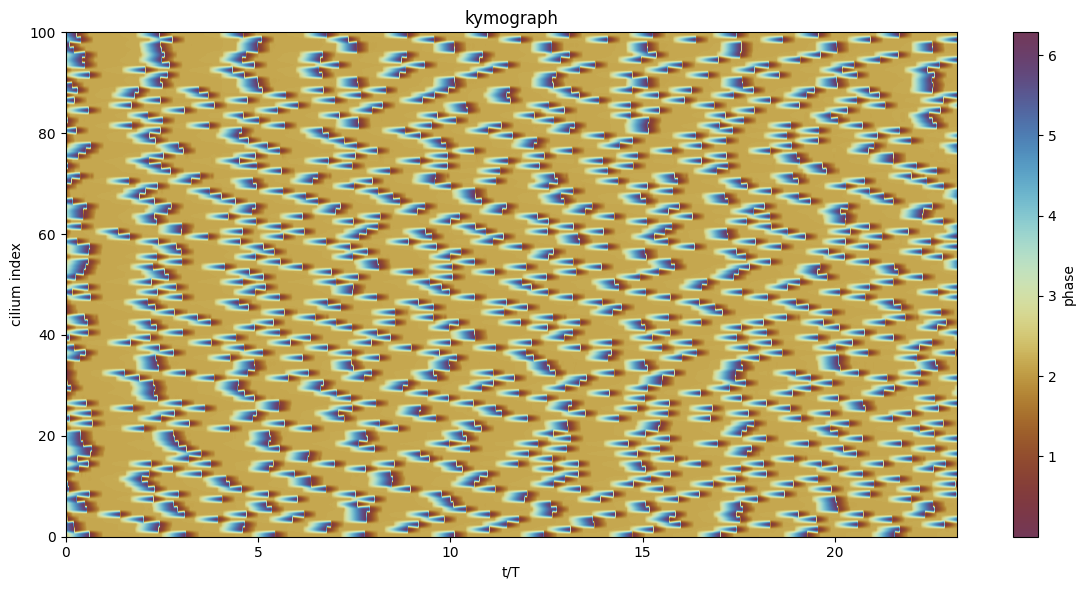

In [53]:
# --- Create Kymograph ---
fig_kymo, ax_kymo = plt.subplots(figsize=(12, 6))

# Transpose phases for kymograph: (num_fils, time)
phases_for_kymo = phases.T

# Create the kymograph using imshow
im = ax_kymo.imshow(phases_for_kymo, aspect='auto', cmap=cmc.romaO, origin='lower',
                    extent=[time[0], time[-1], 0, num_fils])

# Add a colorbar
cbar_kymo = fig_kymo.colorbar(im, ax=ax_kymo)
cbar_kymo.set_label('phase')

# Set labels and title
ax_kymo.set_xlabel('t/T')
ax_kymo.set_ylabel('cilium index')
ax_kymo.set_title('kymograph')

plt.tight_layout()
plt.show()

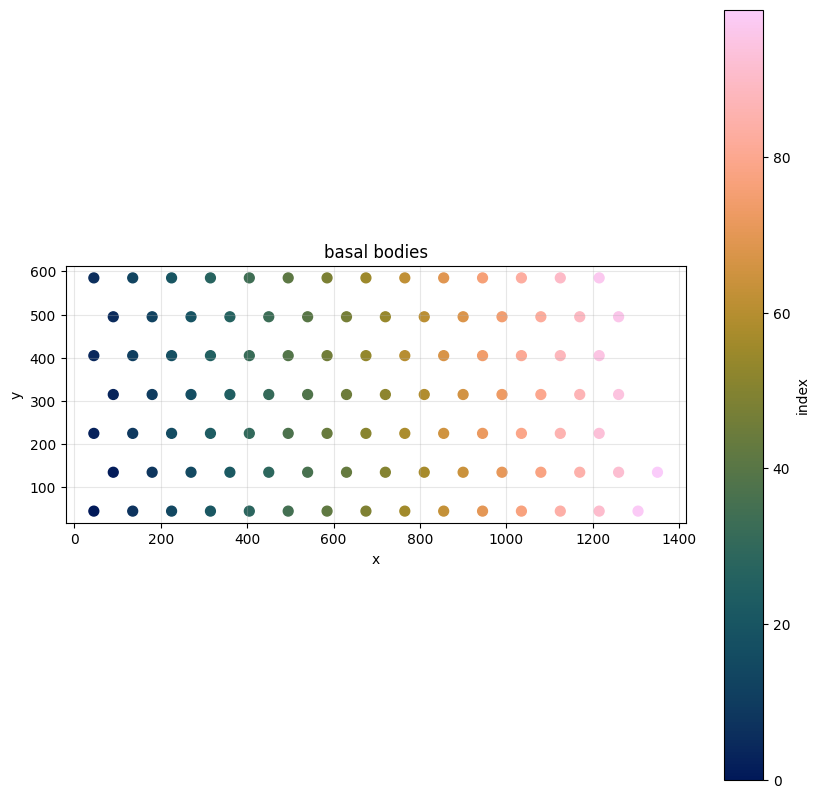

In [54]:
# --- Plot Cilia Positions ---
fig_pos, ax_pos = plt.subplots(figsize=(10, 10))

# Get the base positions of all cilia
base_positions = seg_positions[0, :, 0, :]
x_coords = base_positions[:, 0]
y_coords = base_positions[:, 1]

# Create an array of indices for coloring
indices = np.arange(num_fils)

# Create the scatter plot
scatter = ax_pos.scatter(x_coords, y_coords, c=indices, cmap=cmc.batlow, s=50)

# Add a colorbar
cbar_pos = fig_pos.colorbar(scatter, ax=ax_pos)
cbar_pos.set_label('index')

# Set labels and title
ax_pos.set_xlabel('x')
ax_pos.set_ylabel('y')
ax_pos.set_title('basal bodies')
ax_pos.set_aspect('equal', adjustable='box')
ax_pos.grid(True, alpha=0.3)

plt.show()